# Digit classification using multiple ML algorithms

In this project we implement various machine learning algorithms from scratch and compare their accuracy.
We will be training our model on the MNIST database of Handwritten digits, using:
* Logistic Regression
* Neural Network
* SVM

<small>Draft version. Need to implement graphs and plots for a more clear illustration of results</small>

In [71]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import pandas as pd
import csv
from PIL import Image
import pathlib
%matplotlib inline

In [72]:
def toInt(byteObject):
    return int.from_bytes(byteObject,byteorder="big")

### Function to load the training and/or test set

In [73]:
def loadSet(set_="train"):
    path = pathlib.Path('{}_set.csv'.format(set_))
    if not path.is_file():
        with open("{}-labels.idx1-ubyte".format(set_),"rb") as target:
            magic_num = toInt(target.read(4))
            numItems = toInt(target.read(4))
            examples=[]
            for item in range(numItems):
                examples.append(toInt(target.read(1)))

        with open("{}-images.idx3-ubyte".format(set_),"rb") as target:
            magic_num = toInt(target.read(4))
            numItems = toInt(target.read(4))
            numRows = toInt(target.read(4))
            numCols = toInt(target.read(4))
            images = np.array(np.zeros((numItems,numRows,numCols)))
            for image in range(numItems):
                for row in range(numRows):
                    for col in range(numCols):
                        images[image,row,col]=toInt(target.read(1))

        vec_images = images.reshape(images.shape[0],-1)
        num_examples = len(examples)
        num_features = vec_images.shape[1]

        with open("{}_set.csv".format(set_),"w",newline='') as csv_file:
            csv_writer =  csv.writer(csv_file)
            csv_writer.writerow(["y"]+["pixel"+str(i) for i in range(num_features)])
            for i in range(num_examples):
                csv_writer.writerow([str(examples[i])]+vec_images[i].tolist())
    df = pd.read_csv("{}_set.csv".format(set_))
    return df.iloc[:,1:].values, df.iloc[:,0].values

### Function to normalize the data

In [74]:
def normalize(T):
    T = (T-np.mean(T))/np.std(T)
    return T

### Loading the training set
Our input X will be a feature matrix of size m training examples, with each training example having a feature vector of size 784, representing each pixel.

The labels are stored in the vector y of size m training examples.

In [75]:
X,y = loadSet("train")

# y -> num_examples,
# X -> num_examples x num_features

X = X.astype('float32')
y = y.astype('uint8')

X = normalize(X)

### Loading the test set

In [7]:
X_t, y_t = loadSet("t10k")

y_t = y_t.astype('float32')
X_t = X_t.astype('uint8')

X_t = normalize(X_t)

In [5]:
num_labels = 10

### Function to map the pixels and display the images

In [46]:
def displayData(X, example_width=None, figsize=(10,10), y = None):
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.6, hspace=0.6)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        if i==X.shape[0]: break
        if type(y)!=None:
            ax.title.set_text("Label: "+str(y[i]))
        ax.imshow(X[i].reshape(example_width, example_width),
                  cmap='gray')
        ax.axis('off')

Displaying the examples from the training set

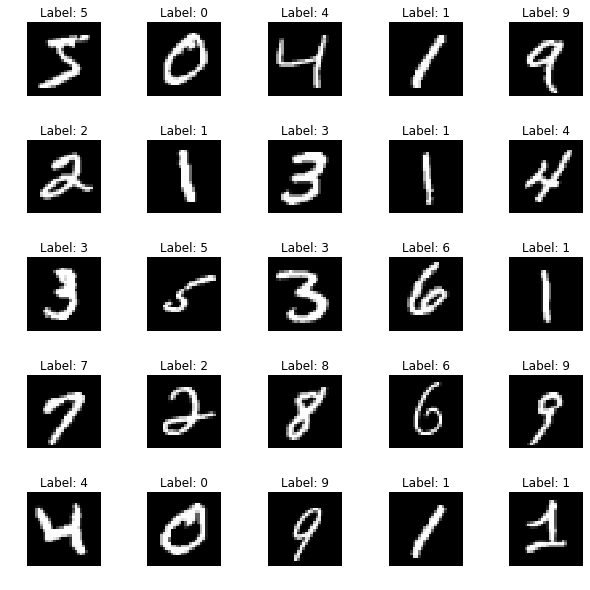

In [77]:
displayData(X[:25,:],y=y[:25])

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

## Training the model using Logistic Regression

In [10]:
def lrCostFunction(theta,X,y,lambda_):
    # X = m x n
    # theta = n,
    # y = m,
    if y.dtype==bool:
        y=y.astype(int)
    
    m,n = X.shape
    
    z = X.dot(theta)
    h = sigmoid(z)

    J = (1/m)*np.sum( (-y)*(np.log(h)) - (1-y)*(np.log(1-h)) )
    J+= (lambda_/(2*m))*np.sum(np.square(theta[1:]))
    
    grad = (1/m)*(X.T.dot(h-y))
    grad[1:] += (lambda_/m)*(theta[1:])
        
    return J, grad

### OneVsAll Method
To implement logistic regression with more than 2 labels, we need to train our set on all labels seperately. 

On each label, we'll assume the rest of the labels are negative examples. This generates a theta matrix of size - num_labels x n+1 (where n is the feature size)

In [11]:
def oneVsAll(X,y,num_labels,lambda_):
    
    m,n = X.shape
    X = np.concatenate((np.ones((m,1)),X),axis=1)
    
    all_theta = np.zeros((num_labels,n+1))
    options = {'maxiter':50}
    for i in range(num_labels):
        print("Training label :",i)
        initial_theta = np.zeros((n+1))
        res = optimize.minimize(lrCostFunction,initial_theta,(X,y==i,lambda_),jac=True,method='CG',options=options)   
        all_theta[i]=res.x
        
    return all_theta

In [82]:
train_examples = 60000
all_theta = oneVsAll(X[:train_examples,:],y[:train_examples],num_labels,0.1)

Training label : 0
Training label : 1
Training label : 2
Training label : 3
Training label : 4
Training label : 5
Training label : 6
Training label : 7
Training label : 8
Training label : 9


### Function to predict the label of input image

In [64]:
def predictOneVsAll(all_theta,X):
    
    # all_theta -> num_labels x num_features+1
    # X -> num_examples x num_features+1
    # pred -> num_examples x num_labels -> num_examples x 1
    
    m,n = X.shape
    
    X = np.concatenate((np.ones((m,1)),X),axis=1)
    
    pred = np.argmax(sigmoid(X.dot(all_theta.T)),axis=1)
    
    return pred

To predict the label, we find the hypothesis of the input w.r.t. theta vector of each 10 labels, and select the hypothesis which is the most confident, i.e. has the highest value.

In [108]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

pred_t = predictOneVsAll(all_theta, X_t)
print('Test Set Accuracy: {:.2f}%'.format(np.mean(pred_t == y_t) * 100))

Training Set Accuracy: 92.24%
Test Set Accuracy: 91.91%


### The examples whose labels were not predicted correctly
We print few of the examples whose labels could not be predicted carefully. This can be further reduced with a more efficient algorithm.

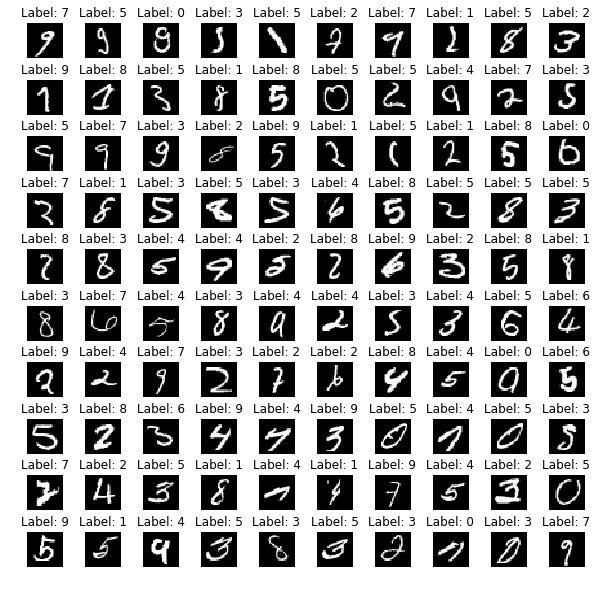

In [109]:
incorrect_indices=np.where(pred!=y)[0]
limit = 100
limit = min(incorrect_indices.size,limit)
displayData(X[incorrect_indices,:][:limit],y=pred[incorrect_indices][:limit])

### Predicting Handwritten Digits not in the MNIST database
Custom inputs have to be pre-processed and normalized, as specified in the MNIST. This pre-processing feature is yet to be added.

Meanwhile, the model can predict custom inputs which have no ambiguity and approximately lie within the pre-processed parameters of the MNIST database. 
1. The size of the input should be 28 x 28 pixels. 
2. The digit should fit a box of 20 x 20 pixels with their aspect ratio preserved. 
3. The centre of mass of the pixels should lie in the centre of the 28 x 28 image.

In [ ]:
im =  Image.open("C:\\Users\\FusionX\\Desktop\\Untitled.png","r")
im = np.array(im.convert('L'))
im = (255-im)/255

t = predictOneVsAll(all_theta,im.reshape(1,-1))

Text(0.5, 1.0, 'label: 3')

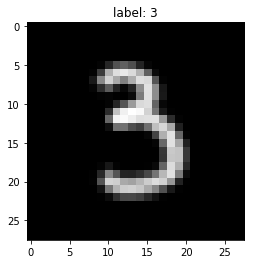

In [115]:
plt.imshow(im,cmap="gray")
plt.title('label: 3')

## Training the model using a Neural Network
In our model, we will be using a single hidden layer as it is more than enough for our requirements. The size of the hidden layer is 300.

In [13]:
input_layer_size = 784
hidden_layer_size = 300
num_labels = 10

### Feedforward and cost function

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

#### with regularized term

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

___

### Backtracking

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.
$$\Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T $$

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

___

### Regularized Neural Network

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$
___

In [14]:
def nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_=0):
    
    # Theta1 = 25 x 785
    # Theta2 = 10 x 26
    
    # X = 60,000 x 784
    # y = 60,000 x 1 ---> 60,000 x 10 (modified)
    
    # a1 = 60,000 x 785
    # a2 = 60,000 x 26
    # a3 = 60,000 x 10
    
    # delta3 = 60,000 x 10
    # delta2 = 60,000 x 26
    
    # Delta1 = 25 x 785
    # Delta2 = 10 x 26
    
    Theta1 = nn_params[:((input_layer_size+1)*hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size+1)*hidden_layer_size):].reshape(num_labels,hidden_layer_size+1)
    
    m = y.size
    y = np.eye(num_labels)[y] 
    
    a1 = np.concatenate([np.ones((m,1)),X],axis=1)
    
    z2 = a1.dot(Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate([np.ones((a2.shape[0],1)),a2],axis=1)

    z3 = a2.dot(Theta2.T)
    a3 = h = sigmoid(z3) 
    
    J = np.sum((1/m)*((-y)*np.log(h) - (1-y)*np.log(1-h)))
    
    reg_term = (lambda_/(2*m))*(np.sum(np.square(Theta1[:,1:])) + np.sum(np.square(Theta2[:,1:])))
    
    J = J + reg_term
    
    delta3 = a3-y
    delta2 = delta3.dot(Theta2[:,1:])*sigmoidGradient(z2)
    
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((num_labels,hidden_layer_size+1))
    
    Delta2 += delta3.T.dot(a2)
    Delta1 += delta2.T.dot(a1)
    
    Theta1_grad = Delta1/m
    Theta2_grad = Delta2/m
    
    Theta1_grad[:,1:] += (lambda_/m)*Theta1[:,1:]
    Theta2_grad[:,1:] += (lambda_/m)*Theta2[:,1:]
    
    grad = np.concatenate([Theta1_grad.ravel(),Theta2_grad.ravel()])
    return J, grad
    

### Sigmoid Gradient

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$


In [15]:
def sigmoidGradient(z):
    g = sigmoid(z)
    return g*(1-g)

### Function to train the Neural Network model using specified parameters

In [16]:
def trainNN(initial_nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_=0):
    options = {'maxiter':100}
    costFunction = lambda p: nnCostFunction(p,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_)
    res = optimize.minimize(costFunction,initial_nn_params,jac=True,method='TNC',options=options)
    nn_params = res.x
    Theta1 = nn_params[:((input_layer_size+1)*hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size+1)*hidden_layer_size):].reshape(num_labels,hidden_layer_size+1)
    return Theta1, Theta2

### Function to predict the label of input given the parameters

In [17]:
def predictNN(X,Theta1,Theta2):
    m = X.shape[0]
    h1 = sigmoid(np.concatenate([np.ones((m,1)),X],axis=1).dot(Theta1.T))
    h2 = sigmoid(np.concatenate([np.ones((m,1)),h1],axis=1).dot(Theta2.T))
    p = np.argmax(h2,axis=1)
    return p

### Function to randomly initialize the weights
We initialize the parameters to be a random value between
$
[-\epsilon,\epsilon]
$

In [18]:
def randInitializeWeights(L_in,L_out,epsilon_init=0.12):
    W = np.zeros((L_in,1+L_out))
    W = np.random.rand(L_out,1+L_in)*2*epsilon_init - epsilon_init
    return W

### Randomly Initializing the parameters
In a neural network, we have to randomly initialize the weights, or otherwise our activation nodes will be redundant and highly inefficient


In [26]:
initial_theta1 = randInitializeWeights(input_layer_size,hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size,num_labels)

initial_nn_params = np.concatenate([initial_theta1.ravel(),initial_theta2.ravel()],axis=0)

### Training the model using the training set


In [27]:
te = 60000 # Max examples in the training set

Theta1, Theta2 = trainNN(initial_nn_params,input_layer_size,hidden_layer_size,num_labels,X[:te,:],y[:te],lambda_=1)

### Using the trained model for prediction on the Test Set

In [54]:
pred = predictNN(X[:te,:],Theta1,Theta2)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred==y[:te])*100))

pred_t = predictNN(X_t[:te,:],Theta1,Theta2)
print('Test Set Accuracy: {:.2f}%'.format(np.mean(pred_t==y_t[:te])*100))


Training Set Accuracy: 96.19%
Test Set Accuracy: 95.88%


The accuracy is similar to the accuracy achieved in the official website of MNIST and so we can conclude our implementation of the Neural Network is correct.

The accuracy is also slightly dependent on the randomly initialized weights and as such might give slightly different results each time depending on the local optima it acquires.

### The examples whose labels were not predicted correctly
We print few of the examples whose labels could not be predicted carefully. This can be further reduced with a more efficient algorithm.

[   80   132   134 ... 59747 59784 59915] (60000,) (60000,)


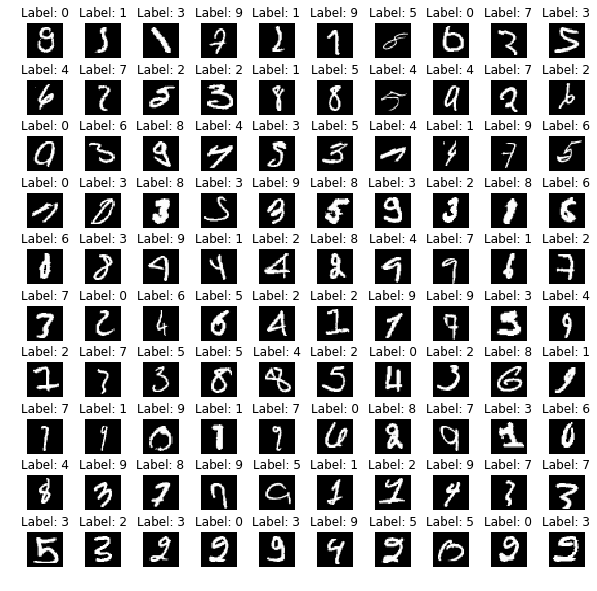

In [69]:
incorrect_indices=np.where(pred!=y)[0]

limit = 100
limit = min(incorrect_indices.size,limit)
displayData(X[incorrect_indices,:][:limit],y=pred[incorrect_indices][:limit])

### Predicting Handwritten Digits not in the MNIST database
Custom inputs have to be pre-processed and normalized, as specified in the MNIST. This pre-processing feature is yet to be added.

Meanwhile, the model can predict custom inputs which have no ambiguity and approximately lie within the pre-processed parameters of the MNIST database. 
1. The size of the input should be 28 x 28 pixels. 
2. The digit should fit a box of 20 x 20 pixels with their aspect ratio preserved. 
3. The centre of mass of the pixels should lie in the centre of the 28 x 28 image.

In [61]:
image_location = "C:\\Users\\FusionX\\Desktop\\Untitled.png"

im =  Image.open(image_location,"r")
im = np.array(im.convert('L'))
im = im.reshape(1,-1)
im = (255-im)/255

t = predictNN(im,Theta1,Theta2)

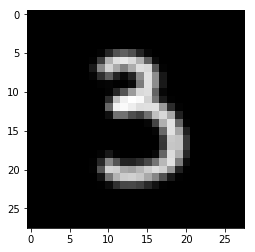

In [62]:
plt.imshow(im.reshape(28,28),cmap='gray')

## Training the model using SVM
Here we train our model using a Support Vector Machine. We will use the SVM classifier from the sklearn module. We will be using a polynomial kernel.

In [37]:
from sklearn.svm import SVC
print('SVM Classifier with gamma = 0.1; Kernel = Polynomial')
te=60000
classifier = SVC(gamma=0.1, kernel='poly', random_state = 0)
classifier.fit(X[:te,:],y[:te])

SVM Classifier with gamma = 0.1; Kernel = Polynomial
(60000, 784) (60000,)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
model_acc = classifier.score(X_t, y_t)

In [70]:
print('\nSVM Trained Classifier Accuracy: {:.2f}%'.format(model_acc*100))


SVM Trained Classifier Accuracy: 98.46%


## Comparison of the 3 models

Accuracy using, 
1. Logistic Regression: 91.91%
2. Neural Network (hidden layers = 1, hidden layer size = 300): 95.88%
3. SVM (polynomial kernels): 98.46%

Here, we can clearly see that the SVM algorithm gives us the most accurate result for our training data. These results are also verified in the official MNIST website.
